In [149]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [150]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               907 non-null    object 
 1   SeasonNumber       907 non-null    int64  
 2   SeasonVersion      907 non-null    int64  
 3   Player             907 non-null    object 
 4   MatchId            907 non-null    object 
 5   Map                907 non-null    object 
 6   Category           907 non-null    object 
 7   Playlist           907 non-null    object 
 8   Input              907 non-null    object 
 9   Queue              907 non-null    object 
 10  PreCsr             907 non-null    int64  
 11  PostCsr            907 non-null    int64  
 12  Rank               907 non-null    int64  
 13  WasAtStart         907 non-null    int64  
 14  WasAtEnd           907 non-null    int64  
 15  WasInProgressJoin  907 non-null    int64  
 16  Mmr                2 non-n

In [151]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 140 to 906
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         641 non-null    int64  
 1   Accuracy        641 non-null    float64
 2   DamageDone      641 non-null    int64  
 3   DamageTaken     641 non-null    int64  
 4   KD              641 non-null    float64
 5   KDA             641 non-null    float64
 6   Kills           641 non-null    int64  
 7   Deaths          641 non-null    int64  
 8   Assists         641 non-null    int64  
 9   MaxSpree        641 non-null    int64  
 10  ExpectedKills   641 non-null    float64
 11  ExpectedDeaths  641 non-null    float64
 12  Score           641 non-null    int64  
 13  Medals          641 non-null    int64  
 14  LengthMinutes   641 non-null    float64
 15  DamageRatio     641 non-null    float64
 16  Damage/Kill     641 non-null    float64
 17  Damage/KA       641 non-null    f

In [152]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [153]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.435669
DmgT/10Min        0.363587
KD                0.315215
Deaths            0.310228
KDA               0.287857
Damage/KA         0.283305
ExcessDeaths      0.262835
DamageTaken       0.245927
ExpectedDeaths    0.200323
Assists/10Min     0.187368
Damage/Kill       0.181400
Kills/10Min       0.143790
LengthMinutes     0.128163
Accuracy          0.119955
MaxSpree          0.107928
DamageDone        0.081156
Assists           0.070419
Score             0.044598
Dmg/10Min         0.041539
DamageRatio       0.039758
BodyPct           0.035852
HSPct             0.030159
MeleePct          0.025836
ExpectedKills     0.024687
Medals            0.021401
GrenadePct        0.015889
Kills             0.012806
ExcessKills       0.007517
PowerPct          0.007060
Shots/10Min       0.002837
Name: Outcome, dtype: float64


In [154]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [155]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,641.0,0.552262,0.497650,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,641.0,52.250733,5.316033,36.800000,48.740000,52.340000,55.290000,80.560000
DamageDone,641.0,5238.836193,1829.052195,666.000000,3870.000000,5027.000000,6453.000000,12673.000000
DamageTaken,641.0,4480.322933,1543.781629,0.000000,3459.000000,4300.000000,5499.000000,9962.000000
KD,641.0,1.268066,0.759551,0.270000,0.850000,1.120000,1.440000,10.000000
KDA,641.0,4.482262,5.635489,-10.000000,0.660000,4.330000,8.000000,31.000000
Kills,641.0,14.544462,6.310827,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,641.0,12.920437,5.170067,0.000000,10.000000,13.000000,16.000000,32.000000
Assists,641.0,8.580343,4.260669,0.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,641.0,3.920437,1.546641,1.000000,3.000000,4.000000,5.000000,10.000000


In [156]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [157]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (641, 30)
Y Shape: (641,)


In [158]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=27)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (512, 30)
X Test Shape: (129, 30)
Y Train Mean: 0.547
Y Test Mean: 0.574


In [159]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)


print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')
# X_train_preprocessed.head()

X Train Processed Shape: (512, 30)
X Train Shape: (512, 30)
X Test Processed Shape: (129, 30)


In [160]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, log_loss, classification_report, confusion_matrix
MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  ll = log_loss(y_test,y_pred)
  clRep = classification_report(y_test, y_pred)
  confM = confusion_matrix(y_test, y_pred)

  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  print("Log Loss: {:.2f}".format(ll))
  print('---------------------------------------------------------')
  print(clRep)
  print('---------------------------------------------------------') 
  # print(confM)
  # print('---------------------------------------------------------') 
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

def coefs(mod):
  # Get the coefficients
  coefficients = mod.coef_[0]

  # Create a dictionary with feature names and their corresponding coefficients
  feature_coefficients = dict(zip(X_train.columns, coefficients))

  # Sort features by coefficients in descending order
  sorted_features = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=False)

  # Print or analyze the top 10 sorted feature coefficients
  print("Top 10 Sorted Feature Coefficients:")
  for feature, coefficient in sorted_features[:10]:
      print(f"{feature}: {coefficient:.2f}")


## Logistic Regression

In [161]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))
print(coefs(logreg))

Unregularized Logistic Regression Accuracy: 0.813953488372093
Acc: 0.814
MAE: 0.19
MSE: 0.19
RMSE: 0.43
R^2 Score: 0.24
OOS R^2 Score: 0.24
Log Loss: 6.71
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        55
           1       0.82      0.86      0.84        74

    accuracy                           0.81       129
   macro avg       0.81      0.81      0.81       129
weighted avg       0.81      0.81      0.81       129

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
BodyPct: -0.01
HSPct: -0.04
PowerPct: -0.06
MeleePct: -0.06
Medals: 0.09
MaxSpree: 0.10
Shots/10Min: -0.10
Damage/Kill: -0.19
DamageRatio: -0.21
GrenadePct: 0.21
None


## Ridge

In [162]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(ridge_cv))
print(ResultsOut(ridge_cv))
print(coefs(ridge_cv.best_estimator_))


LogisticRegression(C=10, solver='saga')
Ridge Accuracy: 0.8062015503875969
   C_param  Accuracy
0    0.001  0.652408
1    0.010  0.722654
2    0.100  0.773368
3    1.000  0.796745
4   10.000  0.800628
5  100.000  0.800628

Acc: 0.806
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.21
OOS R^2 Score: 0.21
Log Loss: 6.99
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        55
           1       0.82      0.85      0.83        74

    accuracy                           0.81       129
   macro avg       0.80      0.80      0.80       129
weighted avg       0.81      0.81      0.81       129

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
BodyPct: -0.00
Shots/10Min: -0.01
DamageRatio: -0.02
HSPct: -0.03
DmgT/10Min: -0.04
MeleePct: -0.05
MaxSpree: -0.05
ExpectedDeaths: 0.05
LengthMinutes: -0.06
PowerPct: -0.12
None


## Lasso

In [163]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(lasso_cv))
print(ResultsOut(lasso_cv))
print(coefs(lasso_cv.best_estimator_))

LogisticRegression(C=10, penalty='l1', solver='saga')
Lasso Accuracy: 0.8062015503875969
   C_param  Accuracy
0    0.001  0.546887
1    0.010  0.546887
2    0.100  0.753874
3    1.000  0.790900
4   10.000  0.800628
5  100.000  0.800628

Acc: 0.806
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.21
OOS R^2 Score: 0.21
Log Loss: 6.99
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        55
           1       0.82      0.85      0.83        74

    accuracy                           0.81       129
   macro avg       0.80      0.80      0.80       129
weighted avg       0.81      0.81      0.81       129

---------------------------------------------------------

Top 10 Sorted Feature Coefficients:
DamageRatio: 0.00
BodyPct: 0.00
Shots/10Min: -0.01
DmgT/10Min: -0.02
MaxSpree: -0.03
HSPct: -0.03
ExpectedDeaths: 0.03
LengthMinutes: -0.04
MeleePct: -0.05
PowerPct: -0.11
None


## ElasticNet

In [164]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
print(paramResults(elastic_cv))
print(ResultsOut(elastic_cv))
print(coefs(elastic_cv.best_estimator_))



LogisticRegression(C=10, l1_ratio=0.25, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8062015503875969
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.546887
1     0.001            0.50  0.546887
2     0.001            0.75  0.546887
3     0.010            0.25  0.703103
4     0.010            0.50  0.666115
5     0.010            0.75  0.572263
6     0.100            0.25  0.771407
7     0.100            0.50  0.759699
8     0.100            0.75  0.757796
9     1.000            0.25  0.794803
10    1.000            0.50  0.792842
11    1.000            0.75  0.792842
12   10.000            0.25  0.800628
13   10.000            0.50  0.800628
14   10.000            0.75  0.800628
15  100.000            0.25  0.800628
16  100.000            0.50  0.800628
17  100.000            0.75  0.800628

Acc: 0.806
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.21
OOS R^2 Score: 0.21
Log Loss: 6.99
---------------------------------------------------------
         

## K-Nearest Neighbours

In [165]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
print(paramResults(knn_cv))
print(ResultsOut(knn_cv))



KNeighborsClassifier(n_neighbors=13)
K-Nearest Neighbors Accuracy: 0.6744186046511628
    n_neighbors_param  Accuracy
0                   1  0.626937
1                   4  0.644394
2                   7  0.667961
3                  10  0.705064
4                  13  0.712964
5                  16  0.701180
6                  19  0.697221
7                  22  0.701180
8                  25  0.677746
9                  28  0.683495
10                 31  0.691357
11                 34  0.693375
12                 37  0.710946
13                 40  0.707044
14                 43  0.707063
15                 46  0.710946
16                 49  0.699200

Acc: 0.674
MAE: 0.33
MSE: 0.33
RMSE: 0.57
R^2 Score: -0.33
OOS R^2 Score: -0.33
Log Loss: 11.74
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.73      0.66        55
           1       0.76      0.64      0.69        74

    accuracy       

## Random Forest

In [166]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=15, n_estimators=300, random_state=69)
Random Forest Accuracy: 0.7209302325581395
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.724538
1               10                 300  0.728384
2               10                 500  0.730345
3               15                 100  0.716828
4               15                 300  0.732305
5               15                 500  0.720617
6               20                 100  0.712888
7               20                 300  0.728422
8               20                 500  0.722578


''

In [167]:
ResultsOut(rf_cv)

Acc: 0.721
MAE: 0.28
MSE: 0.28
RMSE: 0.53
R^2 Score: -0.14
OOS R^2 Score: -0.14
Log Loss: 10.06
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.75      0.69        55
           1       0.79      0.70      0.74        74

    accuracy                           0.72       129
   macro avg       0.72      0.72      0.72       129
weighted avg       0.73      0.72      0.72       129

---------------------------------------------------------


''

<Axes: >

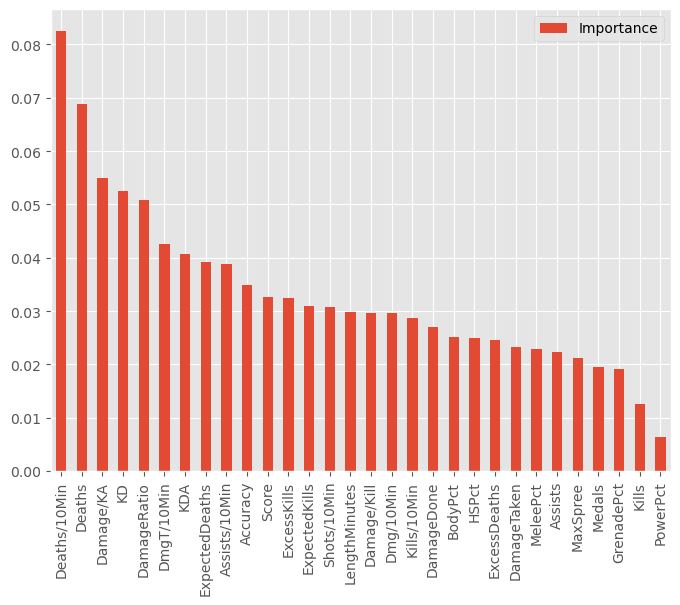

In [168]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [169]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,0.6,0.8,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=300,
                           random_state=69, subsample=0.8)
Gradient Boosed Trees Accuracy: 0.689922480620155
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              0.6   
2                  0.01                2                 100              0.8   
3                  0.01                2                 100              1.0   
4                  0.01                2                 300              0.5   
..                  ...              ...                 ...              ...   
67                 0.10                6                 300              1.0   
68                 0.10                6                 500              0.5   
69                 0.10                6                 500              0.6   
70 

''

In [170]:
ResultsOut(GBRT)

Acc: 0.690
MAE: 0.31
MSE: 0.31
RMSE: 0.56
R^2 Score: -0.27
OOS R^2 Score: -0.26
Log Loss: 11.18
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        55
           1       0.77      0.66      0.71        74

    accuracy                           0.69       129
   macro avg       0.69      0.69      0.69       129
weighted avg       0.70      0.69      0.69       129

---------------------------------------------------------


''

<Axes: >

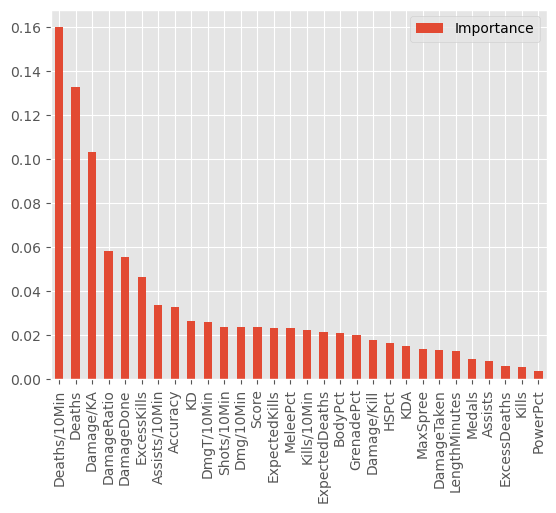

In [171]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [172]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [100,200,300,400,500],'learning_rate': [0.01,0.05,0.1,0.15],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.7131782945736435
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                  0.01                1                 100  0.660156
1                  0.01                1                 200  0.689435
2  

''

In [173]:
ResultsOut(XGB)

Acc: 0.713
MAE: 0.29
MSE: 0.29
RMSE: 0.54
R^2 Score: -0.17
OOS R^2 Score: -0.17
Log Loss: 10.34
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        55
           1       0.77      0.72      0.74        74

    accuracy                           0.71       129
   macro avg       0.71      0.71      0.71       129
weighted avg       0.72      0.71      0.71       129

---------------------------------------------------------


''

<Axes: >

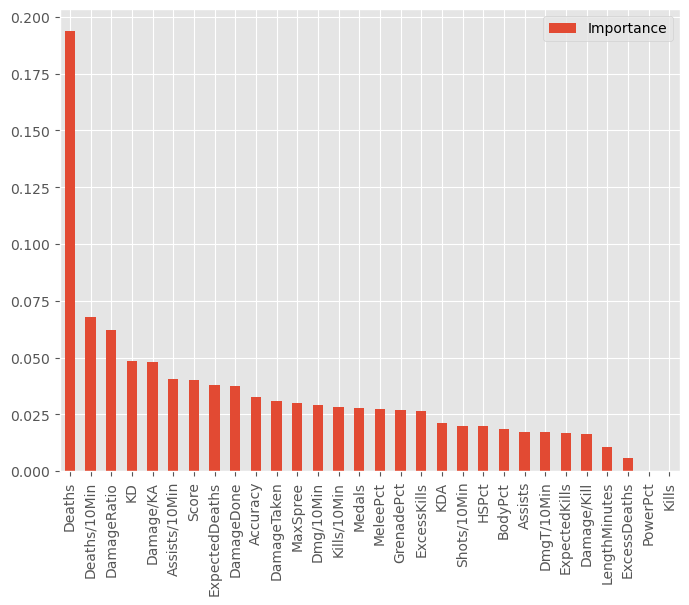

In [174]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [175]:
from sklearn.neural_network import MLPClassifier

param_grid_mlpc = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'],
                'learning_rate': ['constant', 'invscaling', 'adaptive'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
mlpc = GridSearchCV(estimator=MLPClassifier(random_state=61), cv=5, param_grid=param_grid_mlpc, n_jobs=-1)

mlpc.fit(X_train_preprocessed, y_train)
print(mlpc.best_estimator_)
print(f'Neural Net Accuracy: {mlpc.score(X_test_preprocessed, y_test)}')

/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaronpalmer/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aaron

MLPClassifier(activation='identity', alpha=0.01, random_state=61)
Neural Net Accuracy: 0.813953488372093


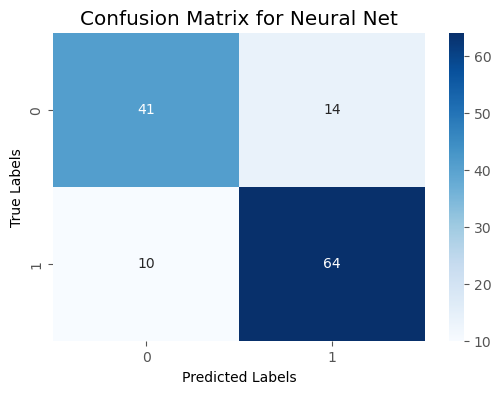

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

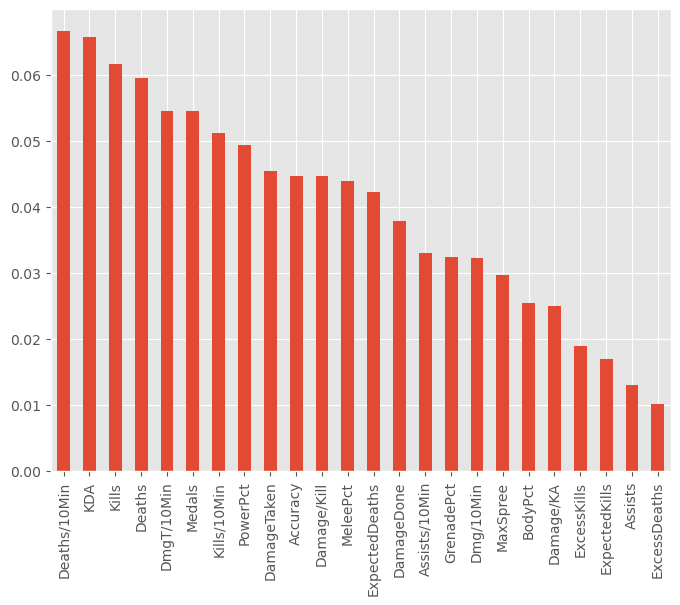

In [176]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, mlpc.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(mlpc.best_estimator_.coefs_[0].flatten()[:30], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch NN

In [177]:
y_train.shape

(512,)

In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming X_train_preprocessed and y_train are your NumPy arrays
y_train_array = y_train.values
X_train_preprocessed_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate the model
input_size = 30  # Replace with the actual input size
hidden_size = 15 # Replace with the desired hidden layer size
output_size = 2  # Replace with the actual output size
model = SimpleNeuralNet(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model on your trainsets
# Replace X_train and y_train with your actual train data
# Replace num_epochs with the desired number of training epochs
losses = []
accuracies = []
prev_loss = float('inf')
for epoch in range(100000):
    optimizer.zero_grad()
    outputs = model(X_train_preprocessed_tensor)
    loss = criterion(outputs, y_train_tensor)
    if loss >= prev_loss:
        break
    prev_loss = loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Calculate training accuracy
    with torch.no_grad():
        predicted = torch.argmax(outputs, 1)
        correct = (predicted == y_train_tensor).sum().item()
        accuracy = correct / y_train_tensor.size(0)
        accuracies.append(accuracy)

In [ ]:
optimizer = optim.LBFGS(model.parameters(), lr=0.01)

def closure():
    optimizer.zero_grad()
    outputs = model(X_train_preprocessed_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    return loss

# Train the model using the LBFGS optimizer with the closure function
for epoch in range(100000):
    optimizer.step(closure)

KeyboardInterrupt: 

In [ ]:
# Assuming X_test_preprocessed and y_test are your test data
X_test_preprocessed_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_preprocessed_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predicted = torch.argmax(test_outputs, 1)
    test_correct = (test_predicted == y_test_tensor).sum().item()
    test_accuracy = test_correct / y_test_tensor.size(0)

print(f'Test Loss: {test_loss.item()}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Epochs: {len(losses)}')

Test Loss: 0.5502447485923767
Test Accuracy: 0.7480314960629921
Epochs: 100000


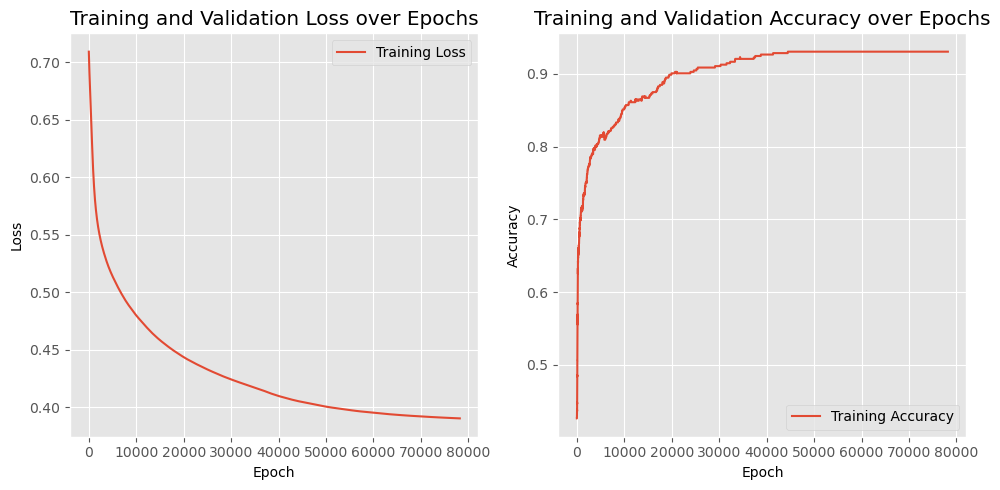

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(losses) + 1)

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Training Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


,Model,ACC,MAE,MSE,RMSE,R2,OOS R2,Log Loss
0,Logistic Regression,0.827,0.173,0.173,0.416,0.304,0.305,6.244
1,MLPC,0.827,0.173,0.173,0.416,0.304,0.305,6.244
2,Ridge,0.772,0.228,0.228,0.478,0.082,0.083,8.230
3,Lasso,0.772,0.228,0.228,0.478,0.082,0.083,8.230
4,ElasticNet,0.772,0.228,0.228,0.478,0.082,0.083,8.230
5,XGBoost,0.732,0.268,0.268,0.517,-0.076,-0.075,9.649
6,Random Forest,0.701,0.299,0.299,0.547,-0.203,-0.201,10.785
7,Gradient Boosted Trees,0.693,0.307,0.307,0.554,-0.235,-0.233,11.069
8,K-Nearest Neighbors,0.646,0.354,0.354,0.595,-0.424,-0.422,12.771


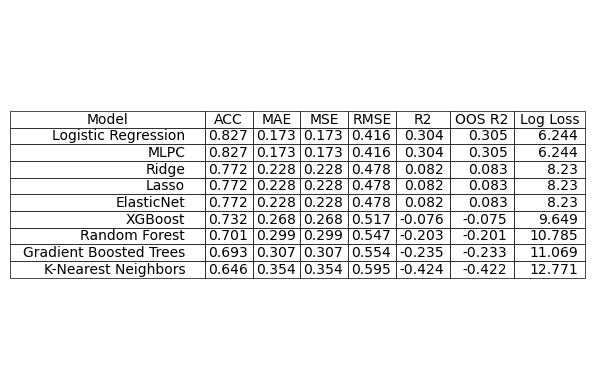

In [ ]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB,mlpc]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost', 'MLPC']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2', 'Log Loss'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        ll = round(log_loss(y_test,y_pred),3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2, ll]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0317.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)


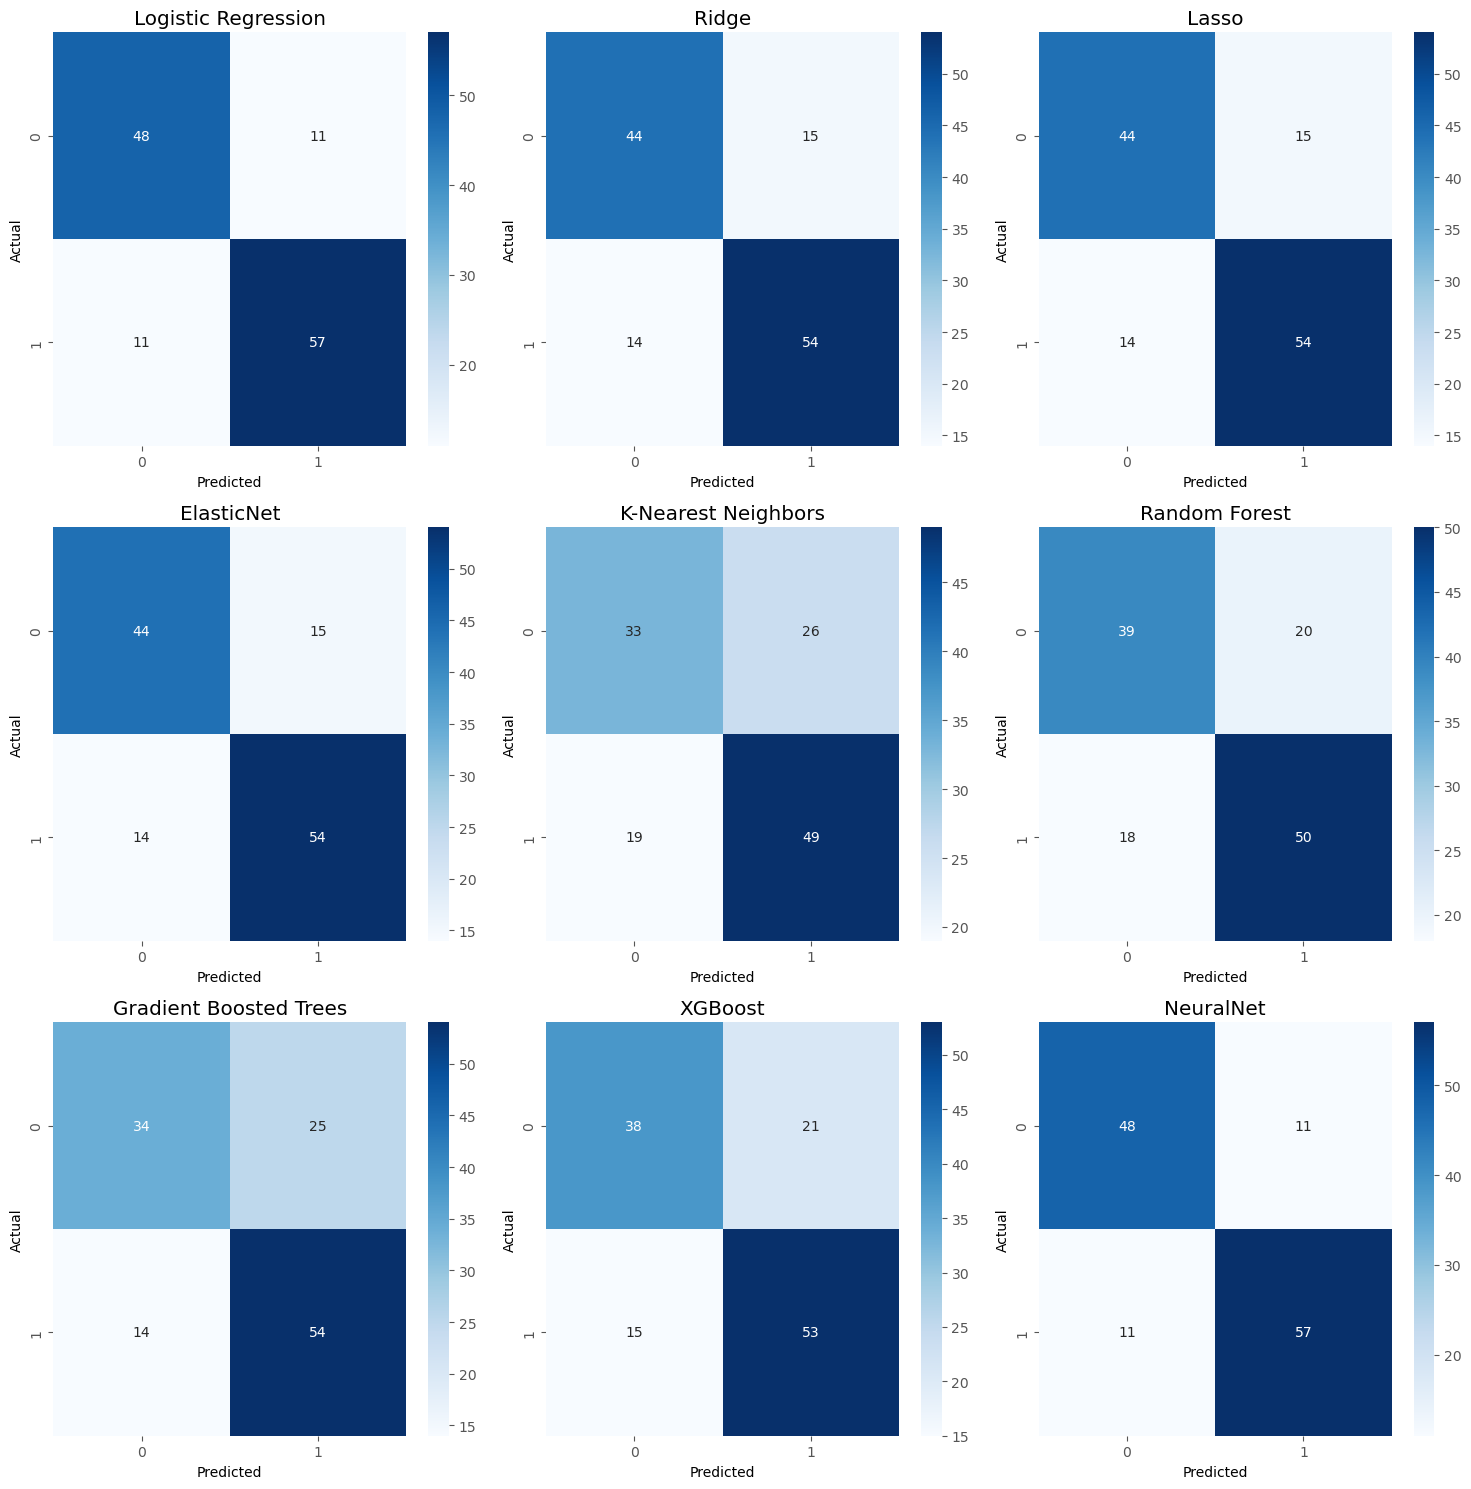

In [ ]:
# Assuming X_test_preprocessed and y_test are your test data
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (model, model_name) in enumerate(zip(modelss, model_namess)):
    y_pred = model.predict(X_test_preprocessed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)
    axs[i//3, i%3].set_xlabel('Predicted')
    axs[i//3, i%3].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('Plots/ConfusionMatrixMultigraph.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f'Runtime: {round(time.perf_counter() - start,2)}s')

Runtime: 134.95s


In [ ]:
X_trainp_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
round(X_trainp_df.describe().transpose(),3).sort_values(by='max',ascending=False)

,count,mean,std,min,25%,50%,75%,max
KD,504.0,-0.0,1.001,-1.300,-0.530,-0.191,0.226,11.389
DamageRatio,504.0,0.0,1.001,-1.778,-0.644,-0.138,0.457,10.575
PowerPct,504.0,-0.0,1.001,-0.356,-0.356,-0.356,-0.356,7.335
Damage/Kill,504.0,-0.0,1.001,-1.915,-0.675,-0.223,0.422,6.469
Shots/10Min,504.0,0.0,1.001,-3.363,-0.571,0.022,0.560,6.048
Damage/KA,504.0,-0.0,1.001,-2.004,-0.652,-0.141,0.482,5.225
Accuracy,504.0,0.0,1.001,-2.780,-0.668,0.025,0.569,5.133
Score,504.0,-0.0,1.001,-2.071,-0.786,-0.118,0.616,5.124
KDA,504.0,0.0,1.001,-2.552,-0.683,-0.019,0.584,4.810
Medals,504.0,0.0,1.001,-1.767,-0.655,-0.098,0.458,4.631
